In [2]:
# open the data set tn.movie_budgets.csv.gz
import pandas as pd

df_budget = pd.read_csv('zippedData/tn.movie_budgets.csv.gz')
df_budget.head() 
df_budget.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5782 entries, 0 to 5781
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   id                 5782 non-null   int64 
 1   release_date       5782 non-null   object
 2   movie              5782 non-null   object
 3   production_budget  5782 non-null   object
 4   domestic_gross     5782 non-null   object
 5   worldwide_gross    5782 non-null   object
dtypes: int64(1), object(5)
memory usage: 271.2+ KB


In [3]:
df_budget.head() 

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,1,"Dec 18, 2009",Avatar,"$425,000,000","$760,507,625","$2,776,345,279"
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875"
2,3,"Jun 7, 2019",Dark Phoenix,"$350,000,000","$42,762,350","$149,762,350"
3,4,"May 1, 2015",Avengers: Age of Ultron,"$330,600,000","$459,005,868","$1,403,013,963"
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,"$317,000,000","$620,181,382","$1,316,721,747"


In [4]:
# check for missing values
df_budget.isnull().sum()

id                   0
release_date         0
movie                0
production_budget    0
domestic_gross       0
worldwide_gross      0
dtype: int64

In [5]:
# check for 0 values in the monetary columns which might indicate missing data even if there are no NULL values
budget_col = (df_budget['production_budget'] == '$0').sum()
domestic_col = (df_budget['domestic_gross'] == '$0').sum()
worldwide_col = (df_budget['worldwide_gross'] == '$0').sum()

print("Zero values in monetary columns:")
print(f"Production budget: {budget_col}")
print(f"Domestic gross: {domestic_col}")
print(f"Worldwide gross: {worldwide_col}")

Zero values in monetary columns:
Production budget: 0
Domestic gross: 548
Worldwide gross: 367


In [6]:
# clean and convert monetary values to float
# identify monetary columns
monetary_columns = ["production_budget", "domestic_gross", "worldwide_gross"]
# clean the monetary_columns
for col in monetary_columns:
    df_budget[col] = df_budget[col].replace('[$,]', '', regex=True).astype(float)
print(df_budget.dtypes)

id                     int64
release_date          object
movie                 object
production_budget    float64
domestic_gross       float64
worldwide_gross      float64
dtype: object


In [ ]:
# Replace the 0 values with the mean gross movies released in the same year

df_budget['release_year'] = df_budget['release_date'].str.split(', ').str[-1]
 
 # replace missing values with mean
def monetary_columns(*cols):
    return list(cols)
for col in monetary_columns('domestic_gross', 'worldwide_gross'):  
    df_budget[col] = df_budget.groupby('release_year')[col].transform(lambda x: x.fillna(x.mean()))
 
print(df_budget[['movie', 'release_date', 'domestic_gross', 'worldwide_gross']].head())
df_budget.isnull().sum()

                                         movie  release_date  domestic_gross  \
0                                       Avatar  Dec 18, 2009     760507625.0   
1  Pirates of the Caribbean: On Stranger Tides  May 20, 2011     241063875.0   
2                                 Dark Phoenix   Jun 7, 2019      42762350.0   
3                      Avengers: Age of Ultron   May 1, 2015     459005868.0   
4            Star Wars Ep. VIII: The Last Jedi  Dec 15, 2017     620181382.0   

   worldwide_gross  
0     2.776345e+09  
1     1.045664e+09  
2     1.497624e+08  
3     1.403014e+09  
4     1.316722e+09  


id                   0
release_date         0
movie                0
production_budget    0
domestic_gross       0
worldwide_gross      0
predicted_gross      0
release_year         0
dtype: int64

#### Q2. What budget ranges for movies are the most profitable - to avoid spending too much, and increase ROI

In [28]:
# check for correlation between the production budget and worldwide gross

correlation = df_budget['production_budget'].corr(df_budget['worldwide_gross'])
correlation

np.float64(0.7483059765694753)

##### The correlation coefficient of 0.75 indicates that there is a strong positive linear relationship between the production budget and the worldwide gross which means that the higher the production budget is, the higher the worldwide gross sales will be.

#### Finding what the optimal budget for the production of a movie is to maximize on the Return on investment (ROI)

In [25]:
# import libraries
import numpy as np  
import matplotlib.pyplot as plt  
import seaborn as sns  
from sklearn.linear_model import LinearRegression

In [35]:
# calculate the ROI
df_budget['ROI'] = df_budget['worldwide_gross'] / df_budget['production_budget']
df_budget.loc[df_budget['production_budget'] == 0, 'ROI'] = np.nan
print(df_budget[['movie', 'production_budget', 'worldwide_gross', 'ROI']].head())

                                         movie  production_budget  \
0                                       Avatar        425000000.0   
1  Pirates of the Caribbean: On Stranger Tides        410600000.0   
2                                 Dark Phoenix        350000000.0   
3                      Avengers: Age of Ultron        330600000.0   
4            Star Wars Ep. VIII: The Last Jedi        317000000.0   

   worldwide_gross       ROI  
0     2.776345e+09  6.532577  
1     1.045664e+09  2.546673  
2     1.497624e+08  0.427892  
3     1.403014e+09  4.243841  
4     1.316722e+09  4.153696  


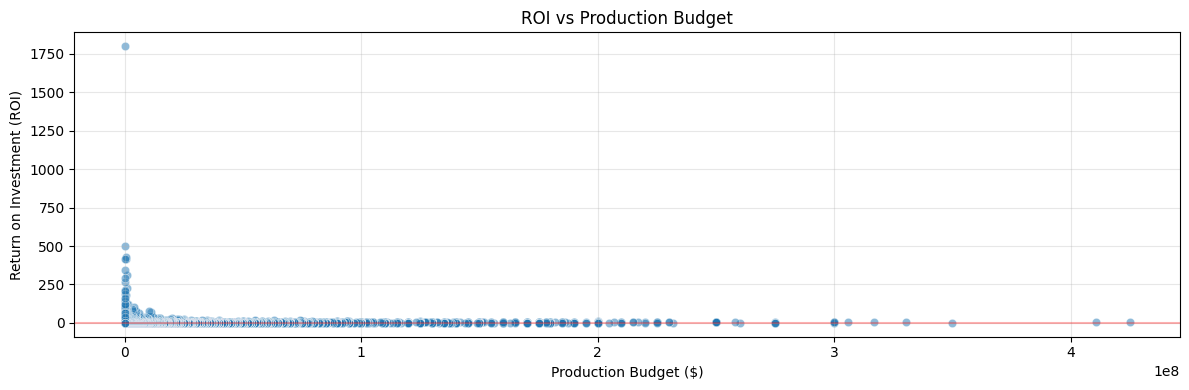

In [39]:
# scatter plot of ROI vs production_budget
plt.figure(figsize=(12, 4))
sns.scatterplot(x='production_budget', y='ROI', data=df_budget, alpha=0.5)
plt.title('ROI vs Production Budget')
plt.xlabel('Production Budget ($)')
plt.ylabel('Return on Investment (ROI)')
plt.axhline(y=1, color='r', linestyle='-', alpha=0.3)  # Line at ROI = 1 (break-even)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


 The scatter plot shows the relationship between the ROI and the production budget. The ROI decreases as the production budget increases.

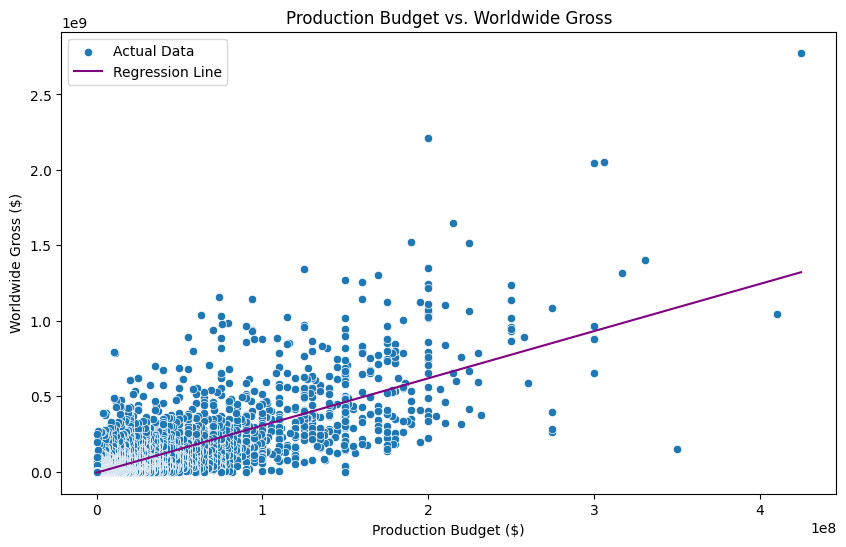

In [26]:
X = df_budget['production_budget'].values.reshape(-1, 1) # independent variable
y = df_budget['worldwide_gross'].values.reshape(-1, 1) #dependent variable

# linear regression model
model = LinearRegression()
model.fit(X, y)

df_budget['predicted_gross'] = model.predict(X)

plt.figure(figsize=(10, 6))
sns.scatterplot(x=df_budget["production_budget"], y=df_budget["worldwide_gross"], label="Actual Data")
sns.lineplot(x=df_budget["production_budget"], y=df_budget["predicted_gross"], color="purple", label="Regression Line")
plt.xlabel("Production Budget ($)")
plt.ylabel("Worldwide Gross ($)")
plt.title("Production Budget vs. Worldwide Gross")
plt.legend()
plt.show()

In [29]:
optimal_budget = df_budget.loc[df_budget["predicted_gross"].idxmax(), "production_budget"]
optimal_budget

np.float64(425000000.0)